# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/cs696ds_lexalytics/Prompting Experiments'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

## Experiment parameters

In [3]:
# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'zero_shot_prompt_logit_softmax_atsc_laptops_bert_amazon_electronics_multiple_prompts'

# Random seed
random_seed = 696

# path to pretrained MLM model folder or the string "bert-base-uncased"
lm_model_path = './bert_base_uncased'

# Prompts to be added to the end of each review text
# Note: pseudo-labels for each prompt should be given in the order of (positive), (negative), (neutral)
sentiment_prompts = [
    {"prompt": "I felt the {aspect} was [MASK].", "labels": ["good", "bad", "ok"]},
    {"prompt": "I [MASK] the {aspect}.", "labels": ["love", "hate", "dislike"]},
    {"prompt": "The {aspect} made me feel [MASK].", "labels": ["good", "bad", "indifferent"]},
    {"prompt": "The {aspect} is [MASK].", "labels": ["good", "bad", "ok"]}
]

# Multiple prompt merging behavior
prompts_merge_behavior = 'sum_logits'

# Test settings
testing_batch_size = 32
testing_domain = 'laptops' # 'laptops', 'restaurants', 'joint'

In [4]:
print("Experiment ID:", experiment_id)

Experiment ID: zero_shot_prompt_logit_softmax_atsc_laptops_bert_amazon_electronics_multiple_prompts


## Package imports

In [5]:
import sys
import os
import random
import shutil
import copy
import inspect

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)

# cuBLAS reproducibility
# https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
# torch.set_deterministic(True)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Python version: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
NumPy version: 1.21.2
PyTorch version: 1.7.0+cu110
Transformers version: 4.3.3


## PyTorch GPU settings

In [6]:
if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 11.0
cuDNN Version: 8004
CUDA Device Name: NVIDIA GeForce RTX 4090 D
CUDA Capabilities: (8, 9)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [7]:
# Load semeval for both domains
laptops_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

restaurants_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

Using custom data configuration default
Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-daa4707b11c9bf16/0.0.1/537edd3b5fdbdb1f3190419cf0a53a4fab3537bc666f17c8c75fa8d0b554e529)
Using custom data configuration default
Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-7dd81a58ddecc330/0.0.1/537edd3b5fdbdb1f3190419cf0a53a4fab3537bc666f17c8c75fa8d0b554e529)


In [8]:
# The dataset chosen for testing
if testing_domain == 'laptops':
    test_set = laptops_dataset['test']
elif testing_domain == 'restaurants':
    test_set = restaurants_dataset['test']
elif testing_domain == 'joint':
    test_set = laptops_dataset['test'] + restaurants_dataset['test']

# Zero-shot ATSC with Prompts

## Load the pretrained LM

In [9]:
# Load pretrained language model
lm = transformers.AutoModelForMaskedLM.from_pretrained("../bert_base_uncased")
tokenizer = transformers.AutoTokenizer.from_pretrained("../bert_base_uncased")

Some weights of the model checkpoint at ../bert_base_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Define a new model with non-trainable softmax head

In [10]:
# Encode the pseudo-label words for each sentiment class
sentiment_word_ids = []

for sp in sentiment_prompts:
    sentiment_word_ids.append(
        [tokenizer.convert_tokens_to_ids(w) for w in sp['labels']])

print(sentiment_word_ids)

classifier_model = utils.MultiPromptLogitSentimentClassificationHead(
    lm=lm,
    num_class=3,
    num_prompts=len(sentiment_prompts), pseudo_label_words=sentiment_word_ids,
    target_token_id=tokenizer.mask_token_id,
    merge_behavior=prompts_merge_behavior)

# Freeze the MLM main layer
for param in classifier_model.lm.parameters():
    param.requires_grad = False

classifier_model = classifier_model.to(device=torch_device)

[[2204, 2919, 7929], [2293, 5223, 18959], [2204, 2919, 24436], [2204, 2919, 7929]]
Detected LM type: bert


## Evaluation with in-domain test set



In [11]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [12]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=testing_batch_size, pin_memory=use_pin_memory)

In [13]:
classifier_model.eval()

predictions_test = torch.Tensor([])
labels_test = torch.Tensor([])

for batch_val in tqdm.notebook.tqdm(test_dataloader):

    reviews_repeated = []
    prompts_populated = []

    for prompt in sentiment_prompts:
        reviews_repeated = reviews_repeated + batch_val["text"]

        for aspect in batch_val["aspect"]:
            prompts_populated.append(prompt['prompt'].format(aspect=aspect))

    batch_encoded = tokenizer(
        reviews_repeated, prompts_populated,
        padding='max_length', truncation='only_first', max_length=256,
        return_tensors='pt')
    
    batch_encoded.to(torch_device)

    labels = batch_val["sentiment"]

    outputs = classifier_model(batch_encoded)

    outputs = outputs.to('cpu')

    predictions_test = torch.cat([predictions_test, outputs])
    labels_test = torch.cat([labels_test, labels])

# Compute metrics
test_metrics = compute_metrics(predictions_test, labels_test)

print(test_metrics)


{'accuracy': 0.5971786833855799, 'f1': 0.39282786885245896, 'precision': 0.4156141114982579, 'recall': 0.4407532991202346}


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results visualization

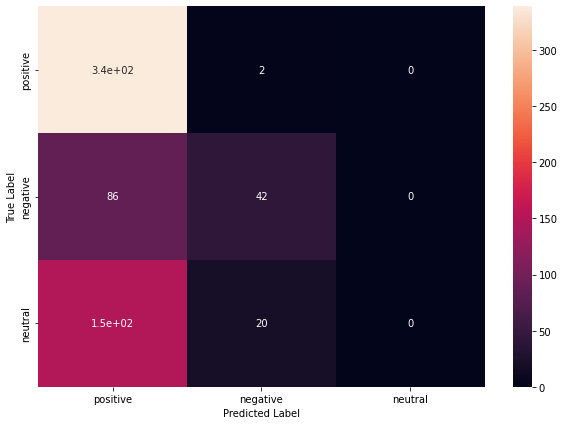

In [14]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.detach().numpy(), predictions_test.detach().numpy().argmax(-1))

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()